## 5.0 Embedding Extraction and Visualization

This notebook generates the song embeddings from previous trained models and visualizes the data.

### Table of Contents
[5.1. Setup](#1.)<br>
[5.1.1 Loading libraries](#1.1)<br>
[5.1.2 Setting data directories](#1.2)<br>
[5.1.3 Defining functions](#1.3)<br>
[5.1.4 Reading in trained models and extracting the song embeddings](#1.4)<br>
[5.1.5 Final preprocessing using Keras model applications](#1.5)<br>

[5.2. Extraction of Embeddings](#2.)<br>
[5.2.1 Loading of trained model and generating the embeddings](#2.1)<br>

[5.3. Visualization using T-SNE](#3.)<br>
[5.3.1 ](#3.1)<br>
[5.3.2 ](#3.2)<br>

[5.4. ](#4.)<br>
[5.4.1 ](#4.1)<br>

### 5.1. Setup <a class="anchor" id="1."></a>

#### 5.1.1 Loading libraries <a class="anchor" id="1.1"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import timeit
import datetime

import keras
from keras import applications
from keras.models import load_model, Model

from os.path import isfile

from sklearn.manifold import TSNE

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.io as pio

C:\Users\kw.UNLOVEDPC\Anaconda3\envs\py3gpu-Env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### 5.1.2 Setting data directories <a class="anchor" id="1.2"></a>

In [2]:
# Set the model description, direcotry and the weights file
model_description = 'vgg16_4v2'
model_dir = f'./models/{model_description}'
print("Directory of model: {}".format(model_dir))
weights_file = 'weights.best.h5'
print("Saved model weights file: {}".format(weights_file))

ds_description = '1x10s'
# Set seed num, if no seed number, set as None
ds_seed_num = 'seed116'

# Set the directory for the spectrograms
data_dir = f'./data/spect_subsample_{ds_description}_np'
print("\nDirectory of spectrograms: {}".format(data_dir))
print("Labels: train_Y_{}_{}_np.npy".format(ds_description, ds_seed_num))

Directory of model: ./models/vgg16_4v2
Saved model weights file: weights.best.h5

Directory of spectrograms: ./data/spect_subsample_1x10s_np
Labels: train_Y_1x10s_seed116_np.npy


In [3]:
genre_dict = {0 : 'Hip-Hop',
              1 : 'Pop',
              2 : 'Folk',
              3 : 'Experimental',
              4 : 'Rock',
              5 : 'International',
              6 : 'Electronic',
              7 : 'Instrumental'}

#### 5.1.3 Defining functions <a class="anchor" id="1.3"></a>

In [4]:
def load_data(data_dir, ds_description, ds_seed_num, str_X, str_Y):
    '''
    Loads the .npy data files generated previously from the pre-processing ipynb
    Note: .npy files need to be in the format: train_spect_{ds_description}_np.npy
    
    Inputs
    ------
    data_dir: directory of the .npy files
    ds_description: e.g. '5x10s'  5 subsamples of 10s length
    str_X: str name of the 'X' data, either: 'spect' or 'X'
    str_Y: str name of the 'Y' data, either: 'labels' or 'Y'
    
    Returns
    -------
    6 numpy arrays of:
        train_{str_X}, train_{str_Y}, val_{str_X}, val_{str_Y}, test_{str_X}, test_{str_Y}
    '''
    assert (str_X in ['spect','X']), "Assertion Error, str_X must be either 'spect' or 'X'."
    assert (str_Y in ['labels','Y']), "Assertion Error, str_Y must be either 'labels' or 'Y'."
    
    if ds_seed_num != None:
        ds_description_with_seed = f'{ds_description}_{ds_seed_num}'
    else:
        ds_description_with_seed = f'{ds_description}'
    
    print("Loading .npy data files...")
    # Start timer
    start_time = timeit.default_timer()

    train_str_X = np.load(f'{data_dir}/train_{str_X}_{ds_description_with_seed}_np.npy')
    val_str_X = np.load(f'{data_dir}/val_{str_X}_{ds_description_with_seed}_np.npy')
    test_str_X = np.load(f'{data_dir}/test_{str_X}_{ds_description_with_seed}_np.npy')

    if str_Y == 'labels':
        train_str_Y = np.load(f'{data_dir}/train_{str_Y}_{ds_description}_np.npy')
        val_str_Y = np.load(f'{data_dir}/val_{str_Y}_{ds_description}_np.npy')
        test_str_Y = np.load(f'{data_dir}/test_{str_Y}_{ds_description}_np.npy')
    else:
        train_str_Y = np.load(f'{data_dir}/train_{str_Y}_{ds_description_with_seed}_np.npy')
        val_str_Y = np.load(f'{data_dir}/val_{str_Y}_{ds_description_with_seed}_np.npy')
        test_str_Y = np.load(f'{data_dir}/test_{str_Y}_{ds_description_with_seed}_np.npy')        
    
    elapsed = str(datetime.timedelta(seconds = timeit.default_timer() - start_time))
    print("", end='\n')
    print("Total processing time (h:mm:ss): {}".format(elapsed[:-7]))
    print("\nLoaded .npy data files, verifying shape of saved data...")
    print(f"Shape of 'train_{str_X}':", train_str_X.shape)
    print(f"Shape of 'train_{str_Y}':", train_str_Y.shape)

    print(f"Shape of 'val_{str_X}':", val_str_X.shape)
    print(f"Shape of 'val_{str_Y}':", val_str_Y.shape)

    print(f"Shape of 'test_{str_X}':", test_str_X.shape)
    print(f"Shape of 'test_{str_Y}':", test_str_Y.shape)
    
    return train_str_X, train_str_Y, val_str_X, val_str_Y, test_str_X, test_str_Y


def mkdir_p(mypath):
    '''
    Creates a directory. equivalent to using mkdir -p on the command line
    '''
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: 
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [5]:
def extract_genre_embeddings(full_set_X, model_dir, weights_file='weights.best.h5'):
    '''
    Loads the trained model, and extracts the genre embeddings for the last layer
    
    Inputs
    ------
    full_set_X = single sample of complete data set (spectrogram input), train, val and test included.
    model_dir = str of directory where trained model weights .h5 file is stored
    weights_file = str of weights .h5 filename
    
    Returns
    -------
    embedding_output from the model
    '''
    
    # Load the model
    print(f"Loading model: {model_dir}/{weights_file}")
    model = load_model(f'{model_dir}/{weights_file}')
    
    # Getting the 2nd last layer output before the softmax layer
    embedding_output_model = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)
    
    # Generate the embeddings for the full set of inputs
    embedding_output = embedding_output_model.predict(full_set_X)
    
    print(f"Shape of full set of Embeddings Output: {embedding_output.shape}")
    
    return embedding_output
   

#### 5.1.4 Reading in train, validation, and test data sets <a class="anchor" id="1.4"></a>

In [6]:
# Read in the spectrogram and labels data from the .npy files
train_X, train_Y, val_X, val_Y, test_X, test_Y = load_data(
    data_dir, ds_description, ds_seed_num, 'X', 'Y')

Loading .npy data files...

Total processing time (h:mm:ss): 0:00:20

Loaded .npy data files, verifying shape of saved data...
Shape of 'train_X': (6394, 431, 128, 3)
Shape of 'train_Y': (6394, 8)
Shape of 'val_X': (800, 431, 128, 3)
Shape of 'val_Y': (800, 8)
Shape of 'test_X': (800, 431, 128, 3)
Shape of 'test_Y': (800, 8)


In [7]:
full_set_X = np.concatenate((train_X, val_X, test_X), axis=0)
full_set_Y = np.concatenate((train_Y, val_Y, test_Y), axis=0)

print("Shape of Full Set X: {}".format(full_set_X.shape))
print("Shape of Full Set Y: {}".format(full_set_Y.shape))

Shape of Full Set X: (7994, 431, 128, 3)
Shape of Full Set Y: (7994, 8)


In [8]:
# Reading in the tracks.csv file
tracks_df = pd.read_csv("./tracks.csv", sep=',', index_col=0, header=[0,1])

train_set_df = tracks_df[tracks_df[('set','split')]=='training']
val_set_df = tracks_df[tracks_df[('set','split')]=='validation']
test_set_df = tracks_df[tracks_df[('set','split')]=='test']

# Generating the concatenated (train, val, test) set of track ids and properties 
full_set_df = pd.concat([train_set_df, val_set_df, test_set_df])
full_set_df.head()

set artist                                             \
             split     id                             name favorites   
track_id                                                               
2         training      1                             AWOL         9   
5         training      1                             AWOL         9   
10        training      6                        Kurt Vile        74   
140       training     54  Alec K. Redfearn & the Eyesores        11   
141       training     54  Alec K. Redfearn & the Eyesores        11   

                       track                                                  \
                       title         date_created genre_top genres favorites   
track_id                                                                       
2                       Food  2008-11-26 01:48:12   Hip-Hop   [21]         2   
5                 This World  2008-11-26 01:48:20   Hip-Hop   [21]         6   
10                   Freeway  2008-11-25 17:49:06       Pop   [10]       178   
140       Queen Of The Wires  2008-11-26 01:44:07      Folk   [17]         5   
141                     Ohio  2008-11-26 01:44:10      Folk   [17]         1   

                           
         interest listens  
track_id                   
2            4656    1293  
5            1933    1151  
10          54881   50135  
140          1593    1299  
141           839     725

#### 5.1.5 Final preprocessing using Keras model applications <a class="anchor" id="1.5"></a>

In [9]:
# Select one of the relevant preprocess_input based on the model used (eg. VGG16, NASNet, etc...)

from keras.applications.vgg16 import preprocess_input

full_set_X = preprocess_input(full_set_X)

### 5.2. Extraction of Embeddings <a class="anchor" id="2."></a>

#### 5.2.1 Loading of trained model and generating the embeddings<a class="anchor" id="2.1"></a>

In [10]:
song_embeddings = extract_genre_embeddings(full_set_X, model_dir, weights_file='weights.best.h5')

Loading model: ./models/vgg16_4v2/weights.best.h5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Shape of full set of Embeddings Output: (7994, 32)


In [11]:
# Saving song embeddings
embedding_dir = './data/song_embeddings'
mkdir_p(embedding_dir)
np.save(f'{embedding_dir}/song_embedding_v02', song_embeddings)

### 5.3 Visualization Using T-SNE <a class="anchor" id="3."></a>

In [12]:
tsne = TSNE(n_components=3, perplexity=50.0, early_exaggeration=12.0, 
            learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, 
            min_grad_norm=1e-07, metric='euclidean', init='random', 
            verbose=1, random_state=None, method='barnes_hut', angle=0.5)
tsne_results = tsne.fit_transform(song_embeddings)

In [25]:
# Saving T-SNE results
np.save(f'{embedding_dir}/tsne_results_ini_p50',tsne_results)

In [29]:
# Load results
tsne_results = np.load(f'{embedding_dir}/tsne_results_ini.npy')

In [13]:
full_set_df['tsne-3d-one'] = tsne_results[:,0]
full_set_df['tsne-3d-two'] = tsne_results[:,1]
full_set_df['tsne-3d-three'] = tsne_results[:,2]

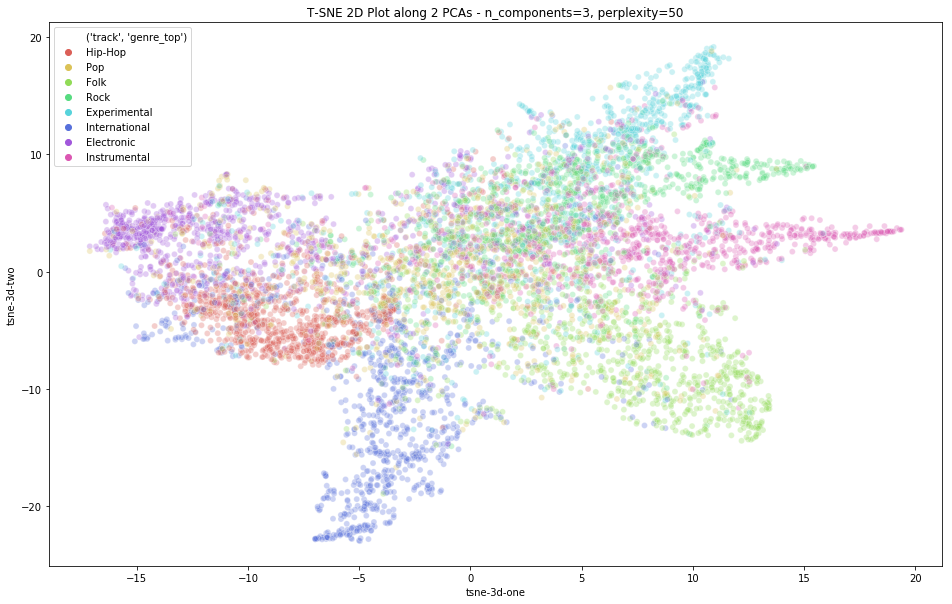

In [14]:
# 2D plot

plt.figure(figsize=(16,10))
ax = sns.scatterplot(x="tsne-3d-one", y="tsne-3d-two",
                     hue=('track','genre_top'),
                     palette=sns.color_palette("hls", 8),
                     data=full_set_df,
                     legend="full",
                     alpha=0.3)

ax.set_title('T-SNE 2D Plot along 2 PCAs - n_components=3, perplexity=50')
plt.show()

In [74]:
# 3D plot

plotly.tools.set_credentials_file(username='kuangweihuang', api_key='NRo8jGkN7UDyKU4c1hwR')

trace_set = []

genre_colors = ['hsl('+str(h)+',70%'+',50%)' for h in np.linspace(0, 255, len(genre_dict))]

for i in range(len(genre_dict)):
    
    trace_set.append(go.Scatter3d(x=full_set_df[full_set_df[('track','genre_top')]==genre_dict[i]]["tsne-3d-one"], 
                                  y=full_set_df[full_set_df[('track','genre_top')]==genre_dict[i]]["tsne-3d-two"],
                                  z=full_set_df[full_set_df[('track','genre_top')]==genre_dict[i]]["tsne-3d-three"],
                                  mode='markers', name=genre_dict[i],
                                  hovertemplate = "<i>Title</i>: %{text}"
                                                  "<br><i>PCA-One</i>: %{x}"
                                                  "<br><i>PCA-Two</i>: %{y}"
                                                  "<br><i>PCA-Three</i>: %{z}",
                                  marker=dict(size=3, 
                                              line=dict(width=0.1),
                                              color=genre_colors[i],
                                              opacity=.7),
                                  text = full_set_df[full_set_df[('track','genre_top')]==genre_dict[i]][('track','title')]
                                 )
                    )

layout = go.Layout(margin=dict(l=0, r=0, b=0, t=50),
                   title= 'T-SNE 3D Plot along 3 PCAs - n_components=3, perplexity=50',
                   hovermode= 'closest',
                   width=900, height=700,
                   scene = dict(xaxis = dict(title='TSNE-PCA-One'),
                               yaxis = dict(title='TSNE-PCA-Two'),
                               zaxis = dict(title='TSNE-PCA-Three'),
                               ),
                  )

fig = go.Figure(data=trace_set, layout=layout)
py.iplot(fig, filename='T-SNE 3D Plot along 3 PCAs - n_components=3, perplexity=50')

#### 5.3.1 Testing Different Perplexities <a class="anchor" id="3.1"></a>

In [75]:
def gen_tsne_results(song_embeddings, embedding_dir, n_components=3, perplexity_list=[5,10,20,30,40,50,75], save=True):
    '''
    Generates a set of T-SNE results for a list of perplexities
    
    Inputs
    ------
    song_embeddings:
    embedding_dir: 
    n_components: default 3
    perplexity_list
    save: flag for saving

    Returns
    -------
    A set of T-SNE results.  Also saves the results to the drive
    '''
    # Define an empty list
    tsne_results_set = []
    
    for i, p in zip(range(len(perplexity_list)), perplexity_list):
        # Instantiate a tsne
        tsne = TSNE(n_components=3, perplexity=p, early_exaggeration=12.0, 
                    learning_rate=200.0, n_iter=5000, n_iter_without_progress=300, 
                    min_grad_norm=1e-07, metric='euclidean', init='random', 
                    verbose=1, random_state=None, method='barnes_hut', angle=0.5)
        
        tsne_results_set.append(tsne.fit_transform(song_embeddings))
    
        if save==True:
            np.save(f'{embedding_dir}/tsne_results_set1_p{p}',tsne_results_set[i])
    
    return tsne_results_set

In [ ]:
# Still running...
tsne_results_set = gen_tsne_results(song_embeddings, embedding_dir, n_components=3, perplexity_list=[5,10,20,30,40,50,75], save=True)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 7994 samples in 0.014s...
[t-SNE] Computed neighbors for 7994 samples in 0.682s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7994
[t-SNE] Computed conditional probabilities for sample 2000 / 7994
[t-SNE] Computed conditional probabilities for sample 3000 / 7994
[t-SNE] Computed conditional probabilities for sample 4000 / 7994
[t-SNE] Computed conditional probabilities for sample 5000 / 7994
[t-SNE] Computed conditional probabilities for sample 6000 / 7994
[t-SNE] Computed conditional probabilities for sample 7000 / 7994
[t-SNE] Computed conditional probabilities for sample 7994 / 7994
[t-SNE] Mean sigma: 0.580806
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.158783
